# EDA, Exploration

### Imports

In [ ]:
# import csv
# from pathlib import Path

# # Mapping espèces → taxon_id
# SPECIES_INFO = [
#     {"name": "Aurelia aurita", "preferred_common_name": "Common Moon Jelly", "taxon_id": 48328},
#     {"name": "Pelagia noctiluca", "preferred_common_name": "Mauve Stinger", "taxon_id": 256089},
#     {"name": "Chrysaora hysoscella", "preferred_common_name": "Compass Jelly", "taxon_id": 360314},
#     {"name": "Cotylorhiza tuberculata", "preferred_common_name": "Fried Egg Jelly", "taxon_id": 324852},
#     {"name": "Rhizostoma pulmo", "preferred_common_name": "Barrel Jelly", "taxon_id": 319371},
# ]

# # Dossier racine contenant les images
# ROOT_DIR = Path("data/images")

# # Fichier CSV de sortie
# OUTPUT_CSV = Path("data/metadata/jellyfish_dataset.csv")

# # Construction du mapping nom_dossier → (taxon_id, species_name)
# species_map = {}
# for entry in SPECIES_INFO:
#     folder_name = entry["name"].replace(" ", "_")  # Ex: "Aurelia aurita" → "Aurelia_aurita"
#     species_map[folder_name] = (entry["taxon_id"], entry["name"])

# rows = []
# for folder, (taxon_id, species_name) in species_map.items():
#     folder_path = ROOT_DIR / folder
#     if not folder_path.exists():
#         print(f"[WARNING] Folder not found: {folder_path}")
#         continue

#     for img_path in folder_path.glob("*.jpg"):
#         rows.append([str(img_path), taxon_id, species_name])

# # Écriture du CSV
# with OUTPUT_CSV.open("w", newline="", encoding="utf-8") as f:
#     writer = csv.writer(f)
#     writer.writerow(["image_path", "taxon_id", "species_name"])
#     writer.writerows(rows)

# print(f"[OK] CSV written with {len(rows)} rows → {OUTPUT_CSV}")


[OK] CSV written with 2733 rows → data/metadata/jellyfish_dataset.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [3]:
# Path to CSV file
csv_path = "data/metadata/jellyfish_dataset.csv"


# Load dataset
df = pd.read_csv(csv_path)
print(df.head(5))

                                   image_path  taxon_id    species_name
0  data/images/Aurelia_aurita/175805603_0.jpg     48328  Aurelia aurita
1  data/images/Aurelia_aurita/188767148_0.jpg     48328  Aurelia aurita
2  data/images/Aurelia_aurita/188767148_1.jpg     48328  Aurelia aurita
3   data/images/Aurelia_aurita/67196674_0.jpg     48328  Aurelia aurita
4   data/images/Aurelia_aurita/67196672_0.jpg     48328  Aurelia aurita


### Find invalid images

In [4]:
import tensorflow as tf

bad_images = []

for path in df['image_path']:
    try:
        img_data = tf.io.read_file(path)
        tf.image.decode_jpeg(img_data, channels=3)
    except tf.errors.InvalidArgumentError:
        print(f"Fichier invalide : {path}")
        bad_images.append(path)
    except Exception as e:
        print(f"Autre erreur sur {path} : {e}")
        bad_images.append(path)

print(f"\nNombre de fichiers problématiques : {len(bad_images)}")


I0000 00:00:1760634844.047226   31510 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2113 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Fichier invalide : data/images/Pelagia_noctiluca/132824944_0.jpg
Fichier invalide : data/images/Pelagia_noctiluca/144216976_0.jpg
Fichier invalide : data/images/Cotylorhiza_tuberculata/132828545_0.jpg
Fichier invalide : data/images/Rhizostoma_pulmo/83106323_1.jpg

Nombre de fichiers problématiques : 4


In [ ]:
df = df[~df['image_path'].isin(bad_images)]
df.to_csv("data/metadata/jellyfish_dataset_cleaned.csv", index=False)

### Check dataset


In [7]:
nb_total = len(df)
nb_images_uniques = df['image_path'].nunique()

print(f"Lignes totales : {nb_total}")
print(f"Images uniques : {nb_images_uniques}")

print(f"Nombre total d'images : {len(df)}")
print("\nColonnes disponibles :")
print(df.columns)

# Nombre d'espèces uniques
print(f"\nNombre d'espèces : {df['species_name'].nunique()}")



Lignes totales : 2729
Images uniques : 2729
Nombre total d'images : 2729

Colonnes disponibles :
Index(['image_path', 'taxon_id', 'species_name'], dtype='object')

Nombre d'espèces : 5


### Images exemples

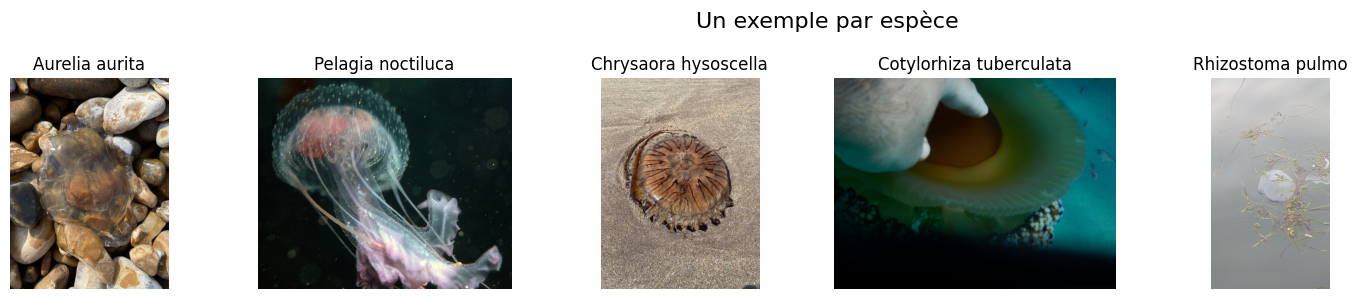

In [8]:
def show_sample_images_per_species(df):
    species_list = df['species_name'].unique()[:6]
    
    plt.figure(figsize=(18, 3))
    
    for i, species_name in enumerate(species_list):
        # Sélectionner une image aléatoire pour cette espèce
        sample = df[df['species_name'] == species_name].sample(n=1).iloc[0]
        
        img = cv2.imread(sample['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, 6, i + 1)
        plt.imshow(img)
        plt.title(f"{species_name}", fontsize=12)
        plt.axis('off')
    
    plt.suptitle("Un exemple par espèce", fontsize=16)
    plt.tight_layout()
    plt.show()

# Afficher une image par espèce
show_sample_images_per_species(df)

### Dataset distribution

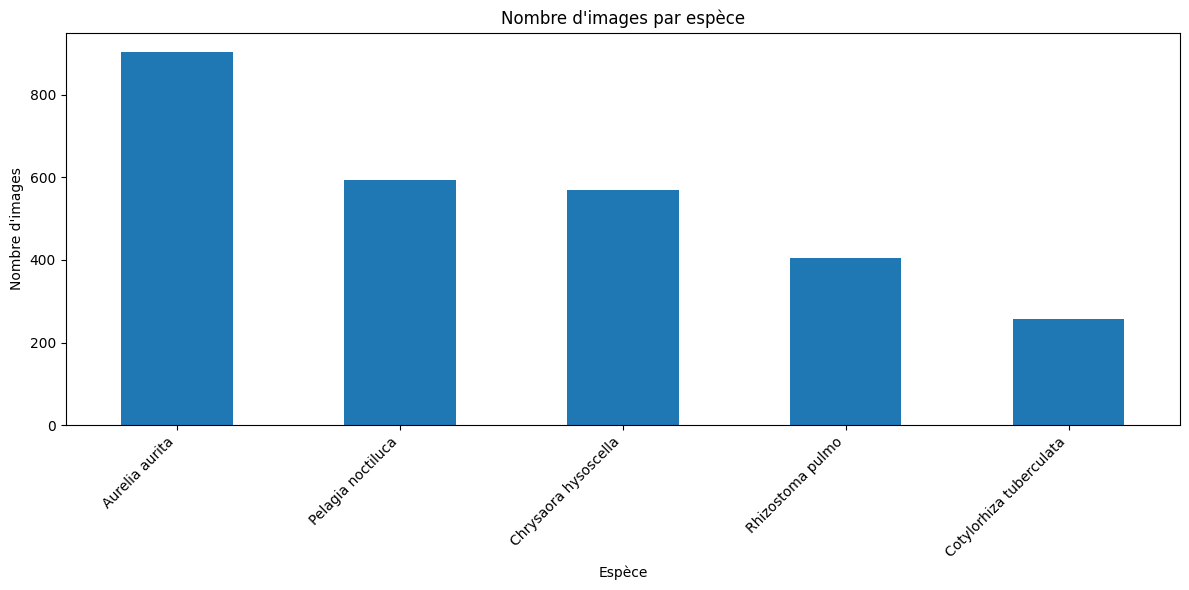

In [ ]:
species_counts = df['species_name'].value_counts()

plt.figure(figsize=(12, 6))
species_counts.plot(kind='bar')
plt.title("Nombre d'images par espèce")
plt.xlabel("Espèce")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#TODO: combiner les 2


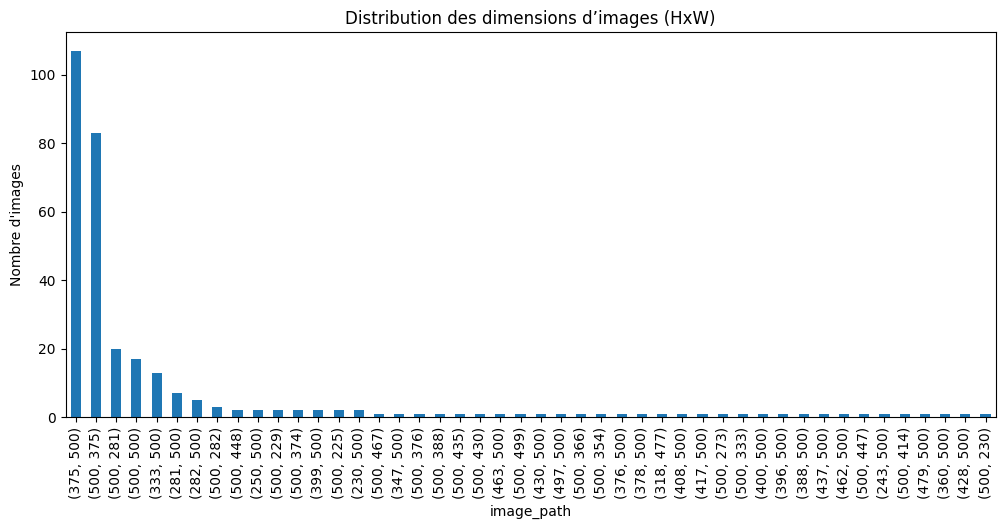

In [10]:
def get_image_shape(image_path):
    img = cv2.imread(image_path)
    return img.shape[:2] if img is not None else (None, None)
  

# Apply on a sample to speed up
sample_df = df.sample(300)
shapes = sample_df['image_path'].apply(get_image_shape)

# Shapes distribution
shape_counts = shapes.value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
shape_counts.plot(kind='bar')
plt.title("Distribution des dimensions d’images (HxW)")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=90)
plt.show()
